
- Repeat for different actions - e.i. changing percent to sell or buy all
- Train n-step sarsa (n = 0, n = 2, n = 4, n = 10, n = 20)


- Try negative rewards
    - Repeat for different actions - e.i. changing percent to sell or buy all
    - Train MC and SARSA 
        - Compare which one performs better in training
        - Compare which one performs better on Test time period

- Plot percent of state space experienced
- Plot actions that resulted in Gain - may only be relevant for 100%  buy sell version




### NO SOFTMAX IN ENV

In [239]:


import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from environments.portfolio_without_softmax import StockPortfolioEnv
import os
from agents.single_stock_tabular import nstep_sarsa_single_stock

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [240]:

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [241]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [242]:
## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583910,607541200,AAPL,2,-0.082603,3.093651,2.454292,42.254777,-80.462494,16.129793,2.749560,2.861671,"[[0.001348967410057769, 0.0004284121156666803,...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839504,6287200,AMGN,2,0.156755,42.707028,40.853195,51.060582,51.523069,10.432018,41.058033,40.603775,"[[0.001348967410057769, 0.0004284121156666803,...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580751,9625600,AXP,2,-0.935582,18.646867,12.660474,42.554846,-75.437609,25.776759,15.744063,17.616374,"[[0.001348967410057769, 0.0004284121156666803,...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005901,5443100,BA,2,-0.279799,32.174384,28.867839,47.440261,156.995115,5.366299,30.327214,32.389915,"[[0.001348967410057769, 0.0004284121156666803,...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608656,6277400,CAT,2,0.655610,30.348089,25.455647,51.205311,98.374152,26.331746,26.689551,26.423592,"[[0.001348967410057769, 0.0004284121156666803,...",tic AAPL AMGN AXP ...


In [243]:
TRAIN_START = '2009-01-01'
TRAIN_END ='2020-07-01'
TEST_START = '2020-07-01'
TEST_END = '2021-10-31'

train = data_split(df, TRAIN_START, TRAIN_END)
trade = data_split(df,TEST_START, TEST_END)

In [244]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}


Stock Dimension: 28, State Space: 28


In [245]:
EPISODES = 500
TEST_TRIALS = 1000

In [246]:
two_step_sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [247]:
two_step_sarsa_post_training_env, two_step_sarsa_training_episodes, two_step_sarsa_Q = nstep_sarsa_single_stock(two_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=2, stock=0, aggressive=True)

Episode:  50%|█████     | 1/2 [00:05<00:05,  5.97s/it]

begin_total_asset:1000000
end_total_asset:11736267.357573684
Sharpe:  1.2149757741162264


begin_total_asset:1000000
end_total_asset:2443846.3684587227
Sharpe:  0.4811789427121572


In [248]:
two_step_sarsa_test_values = []
two_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
for i in range(TEST_TRIALS):
    two_step_sarsa_test_post_training_env, two_step_sarsa_test_episode, two_step_sarsa_test_Q  = nstep_sarsa_single_stock(two_step_sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=2, stock=0, q=two_step_sarsa_Q, aggressive=True)
    two_step_sarsa_test_values.append(two_step_sarsa_test_post_training_env.asset_memory)
avg_two_step_sarsa_test_values = np.mean(two_step_sarsa_test_values, axis=0)

begin_total_asset:1000000
end_total_asset:1091901.0784993756
Sharpe:  0.3985888542561771


In [249]:
# two-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
two_step_sarsa_all_episode_rewards = []
for episode in two_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    two_step_sarsa_all_episode_rewards.append(episode_rewards)
two_step_sarsa_final_amounts = [rewards[-1] for rewards in two_step_sarsa_all_episode_rewards]

In [250]:
five_step_sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [251]:
five_step_sarsa_post_training_env, five_step_sarsa_training_episodes, five_step_sarsa_Q = nstep_sarsa_single_stock(five_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=5, stock=0, aggressive=True)

Episode:  50%|█████     | 1/2 [00:06<00:06,  6.56s/it]

begin_total_asset:1000000
end_total_asset:5122232.751434923
Sharpe:  0.8147149704223177


begin_total_asset:1000000
end_total_asset:3318577.9070821665
Sharpe:  0.620024039151686


In [252]:
five_step_sarsa_test_values = []
five_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
for i in range(TEST_TRIALS):
    five_step_sarsa_test_post_training_env, five_step_sarsa_test_episode, five_step_sarsa_test_Q  = nstep_sarsa_single_stock(five_step_sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=5, stock=0, q=five_step_sarsa_Q, aggressive=True)
    five_step_sarsa_test_values.append(five_step_sarsa_test_post_training_env.asset_memory)
avg_five_step_sarsa_test_values = np.mean(five_step_sarsa_test_values, axis=0)

begin_total_asset:1000000
end_total_asset:1178172.0502727078
Sharpe:  0.660364018541677


In [253]:
# five-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
five_step_sarsa_all_episode_rewards = []
for episode in five_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    five_step_sarsa_all_episode_rewards.append(episode_rewards)
five_step_sarsa_final_amounts = [rewards[-1] for rewards in five_step_sarsa_all_episode_rewards]

In [254]:
ten_step_sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [255]:
ten_step_sarsa_post_training_env, ten_step_sarsa_training_episodes, ten_step_sarsa_Q = nstep_sarsa_single_stock(ten_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=10, stock=0, aggressive=True)

Episode:  50%|█████     | 1/2 [00:05<00:05,  5.54s/it]

begin_total_asset:1000000
end_total_asset:3151202.8301008143
Sharpe:  0.584715242271033


begin_total_asset:1000000
end_total_asset:8962289.945774758
Sharpe:  1.0611828252823339


In [256]:
ten_step_sarsa_test_values = []
ten_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
for i in range(TEST_TRIALS):
    ten_step_sarsa_test_post_training_env, ten_step_sarsa_test_episode, ten_step_sarsa_test_Q  = nstep_sarsa_single_stock(ten_step_sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=10, stock=0, q=ten_step_sarsa_Q, aggressive=True)
    ten_step_sarsa_test_values.append(ten_step_sarsa_test_post_training_env.asset_memory)
avg_ten_step_sarsa_test_values = np.mean(ten_step_sarsa_test_values, axis=0)

begin_total_asset:1000000
end_total_asset:1001184.084074911
Sharpe:  0.11196277715939641


In [257]:
# ten-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
ten_step_sarsa_all_episode_rewards = []
for episode in ten_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    ten_step_sarsa_all_episode_rewards.append(episode_rewards)
ten_step_sarsa_final_amounts = [rewards[-1] for rewards in ten_step_sarsa_all_episode_rewards]

In [258]:
twenty_step_sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [259]:
twenty_step_sarsa_post_training_env, twenty_step_sarsa_training_episodes, twenty_step_sarsa_Q = nstep_sarsa_single_stock(twenty_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=20, stock=0, aggressive=True)

Episode:  50%|█████     | 1/2 [00:06<00:06,  6.01s/it]

begin_total_asset:1000000
end_total_asset:5443917.050830973
Sharpe:  0.8675886942131216


begin_total_asset:1000000
end_total_asset:5967428.926561633
Sharpe:  0.9073264095734441


In [260]:
twenty_step_sarsa_test_values = []
twenty_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
for i in range(TEST_TRIALS):
    twenty_step_sarsa_test_post_training_env, twenty_step_sarsa_test_episode, twenty_step_sarsa_test_Q  = nstep_sarsa_single_stock(twenty_step_sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=20, stock=0, q=twenty_step_sarsa_Q, aggressive=True)
    twenty_step_sarsa_test_values.append(twenty_step_sarsa_test_post_training_env.asset_memory)
avg_twenty_step_sarsa_test_values = np.mean(twenty_step_sarsa_test_values, axis=0)

begin_total_asset:1000000
end_total_asset:1223167.7827729105
Sharpe:  0.8489841171031198


In [261]:
# twenty-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
twenty_step_sarsa_all_episode_rewards = []
for episode in twenty_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    twenty_step_sarsa_all_episode_rewards.append(episode_rewards)
twenty_step_sarsa_final_amounts = [rewards[-1] for rewards in twenty_step_sarsa_all_episode_rewards]

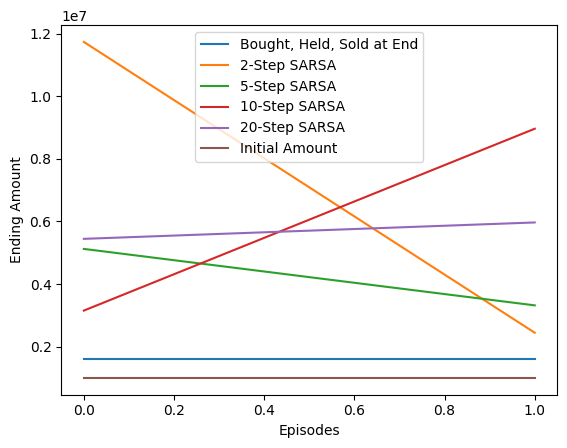

In [262]:
starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value

end_value =trade[(trade['date'] == '2021-10-29') & (trade['tic'] == 'AAPL')]['open'].values[0]
end_amount_if_bought_and_held = end_value * stocks

plt.plot(list(range(EPISODES)), [end_amount_if_bought_and_held] * EPISODES, label='Bought, Held, Sold at End')
plt.plot(list(range(EPISODES)), two_step_sarsa_final_amounts, label='2-Step SARSA')
plt.plot(list(range(EPISODES)), five_step_sarsa_final_amounts, label='5-Step SARSA')
plt.plot(list(range(EPISODES)), ten_step_sarsa_final_amounts, label='10-Step SARSA')
plt.plot(list(range(EPISODES)), twenty_step_sarsa_final_amounts, label='20-Step SARSA')
plt.plot(list(range(EPISODES)), [1_000_000] * EPISODES, label='Initial Amount')
plt.xlabel('Episodes')
plt.ylabel('Ending Amount')
plt.legend()
plt.show()

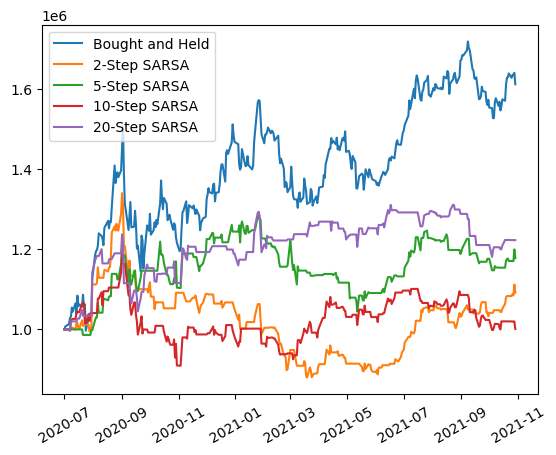

In [263]:
#PLOT COMPARING PORTFOLIO VALUE OF TEST EPISODE AGAINST JUST HOLDING STOCK WITH SARSA AND MC

starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value
values_while_held = trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].to_numpy() * stocks
dates = np.asarray(trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['date'], dtype='datetime64[s]')
plt.plot(dates, values_while_held, label="Bought and Held")
plt.plot(dates, avg_two_step_sarsa_test_values, label="2-Step SARSA")
plt.plot(dates, avg_five_step_sarsa_test_values, label="5-Step SARSA")
plt.plot(dates, avg_ten_step_sarsa_test_values, label="10-Step SARSA")
plt.plot(dates, avg_twenty_step_sarsa_test_values, label="20-Step SARSA")
plt.xticks(rotation=30)
plt.legend()
plt.show()


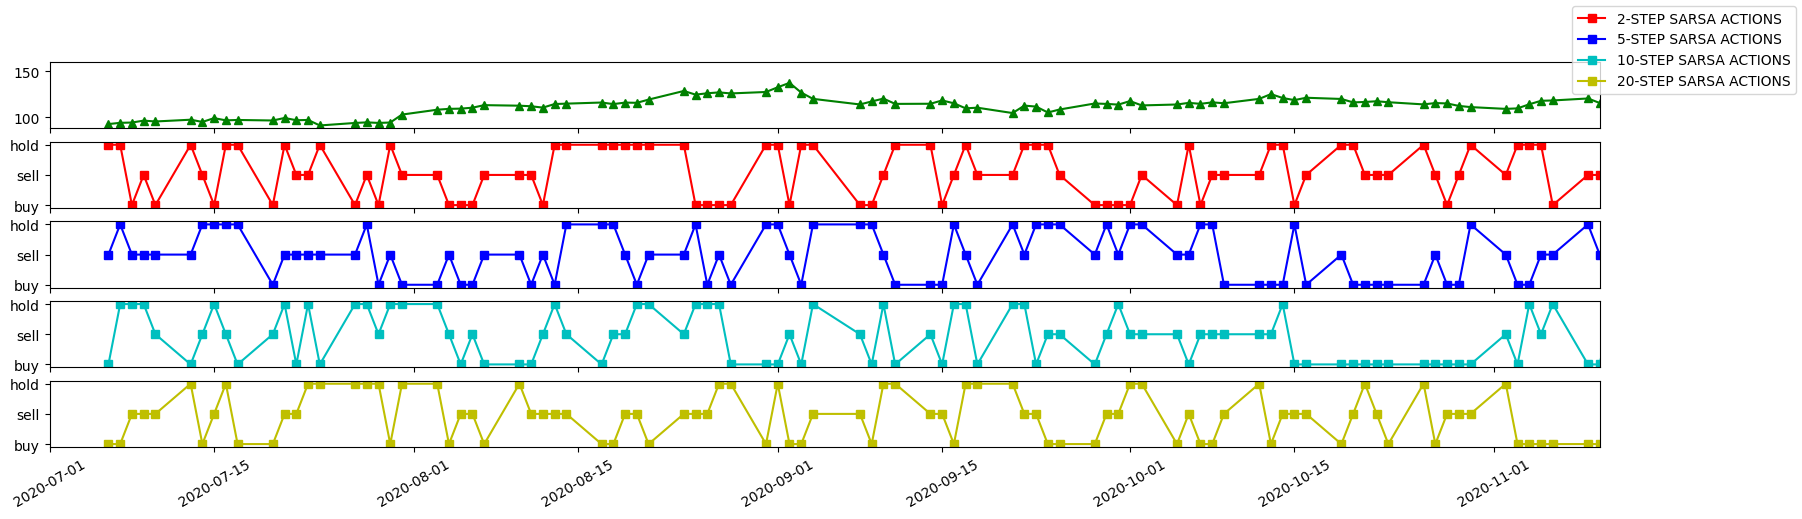

In [264]:
# ACTIONS OVER TEST
two_step_sarsa_test_actions = []
five_step_sarsa_test_actions = []
ten_step_sarsa_test_actions = []
twenty_step_sarsa_test_actions = []
# episode.append((S, A, reward, percent))
action_dates = dates[2:] # account for skipping first two steps to create differences
for step in two_step_sarsa_test_episode[0]:
    action = step[1]
    two_step_sarsa_test_actions.append(action)
for step in five_step_sarsa_test_episode[0]:
    action = step[1]
    five_step_sarsa_test_actions.append(action)
for step in ten_step_sarsa_test_episode[0]:
    action = step[1]
    ten_step_sarsa_test_actions.append(action)
for step in twenty_step_sarsa_test_episode[0]:
    action = step[1]
    twenty_step_sarsa_test_actions.append(action)
fig, axs = plt.subplots(nrows=5, figsize=(20,5), sharex=True)
axs[1].plot(action_dates, two_step_sarsa_test_actions, marker = 's', label = '2-STEP SARSA ACTIONS', c='r')
axs[2].plot(action_dates, five_step_sarsa_test_actions, marker = 's', label = '5-STEP SARSA ACTIONS', c='b')
axs[3].plot(action_dates, ten_step_sarsa_test_actions, marker = 's', label = '10-STEP SARSA ACTIONS', c='c')
axs[4].plot(action_dates, twenty_step_sarsa_test_actions, marker = 's', label = '20-STEP SARSA ACTIONS', c='y')
fig.legend()
plt.xticks(rotation=30)

axs[0].plot(action_dates, trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'][2:], marker = '^', label = 'STOCK VALUE', c='g')
for ax in axs[1:]:
    ax.set_xlim(np.asarray(['2020-07-01', '2020-11-10'],  dtype='datetime64[s]'))
    ax.set_yticks([0, 1, 2]) # buy hold sell
    ax.set_yticklabels(['buy', 'sell', 'hold'])


In [265]:
# LENGTH OF EPISODES and Q TABLE SIZE PLOT